<a href="https://colab.research.google.com/github/P202U/Movie_recommend/blob/main/Neural_Collaborative_Filtering_with_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
path = kagglehub.dataset_download("prajitdatta/movielens-100k-dataset")

100%|██████████| 4.77M/4.77M [00:00<00:00, 6.81MB/s]

Extracting files...


# **Data loading and preprocessing**

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import random

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

print(f"TensorFlow version: {tf.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.19.0
Num GPUs Available:  1


In [3]:
ratings_df = pd.read_csv(os.path.join(path, 'ml-100k', 'u.data'), sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings_df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
movies_df = pd.read_csv(os.path.join(path, 'ml-100k', 'u.item'), sep='|', encoding='latin-1',
                       names=['item_id', 'title', 'release_date', 'video_release_date',
                              'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
                              'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                              'Thriller', 'War', 'Western'])
movies_df.head()

,item_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
print(f"Number of users: {ratings_df['user_id'].nunique()}")
print(f"Number of movies: {ratings_df['item_id'].nunique()}")
print(f'Number of ratings: {len(ratings_df)}')
print(f"Rating range: {ratings_df['rating'].min()} to {ratings_df['rating'].max()}")
print(f"Average rating: {ratings_df['rating'].mean():.2f}")

Number of users: 943
Number of movies: 1682
Number of ratings: 100000
Rating range: 1 to 5
Average rating: 3.53


In [6]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [7]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   item_id             1682 non-null   int64  
 1   title               1682 non-null   object 
 2   release_date        1681 non-null   object 
 3   video_release_date  0 non-null      float64
 4   IMDb_URL            1679 non-null   object 
 5   unknown             1682 non-null   int64  
 6   Action              1682 non-null   int64  
 7   Adventure           1682 non-null   int64  
 8   Animation           1682 non-null   int64  
 9   Children            1682 non-null   int64  
 10  Comedy              1682 non-null   int64  
 11  Crime               1682 non-null   int64  
 12  Documentary         1682 non-null   int64  
 13  Drama               1682 non-null   int64  
 14  Fantasy             1682 non-null   int64  
 15  Film-Noir           1682 non-null   int64  
 16  Horror

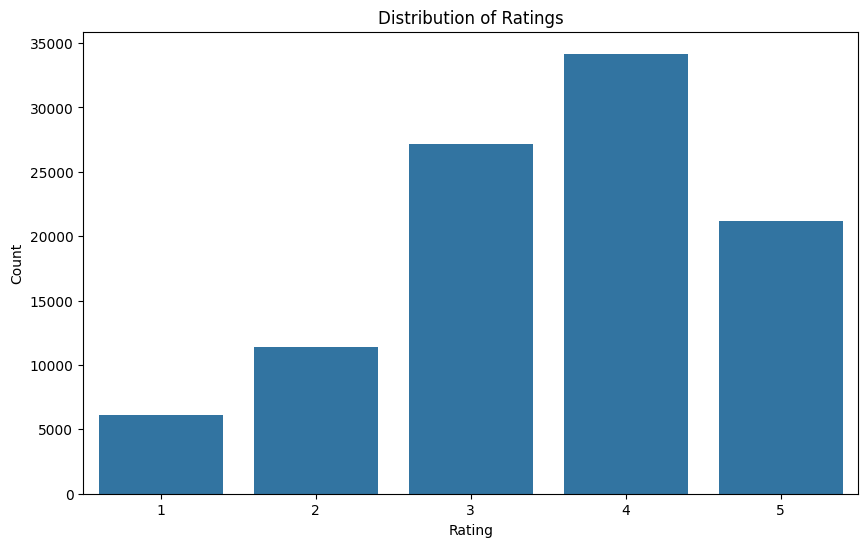

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=ratings_df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [9]:
ratings_df['label'] = ratings_df['rating'].apply(lambda x: 1 if x >= 4 else 0)

In [10]:
ratings_df.sample(5)

,user_id,item_id,rating,timestamp,label
75721,877,381,4,882677345,1
80184,815,602,3,878694269,0
19864,94,431,4,891721716,1
76699,416,875,2,876696938,0
92991,500,182,2,883873556,0


# **Data preparation**

In [11]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

print(f"Training: {len(train_df)}")
print(f"Test: {len(test_df)}")

Training: 80000
Test: 20000


In [12]:
num_users = ratings_df['user_id'].max()
num_items = ratings_df['item_id'].max()

print(f"Users: {num_users}")
print(f"Items: {num_items}")

Users: 943
Items: 1682


In [13]:
def create_dataset(df, batch_size=256, train=True):
    ds = tf.data.Dataset.from_tensor_slices((
        {
            "user_id": df['user_id'].values.astype(np.int64),
            "item_id": df['item_id'].values.astype(np.int64)
        },
        df['label'].values.astype(np.float32)
    ))
    if train:
        ds = ds.shuffle(len(df))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [14]:
train_loader = create_dataset(train_df)
test_loader = create_dataset(test_df, train=False)

In [16]:
class NCF(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_dim=32, mlp_layers=[64, 32, 16]):
        super(NCF, self).__init__()

        # GMF Path
        self.user_emb_gmf = layers.Embedding(num_users + 1, embedding_dim, embeddings_initializer='normal')
        self.item_emb_gmf = layers.Embedding(num_items + 1, embedding_dim, embeddings_initializer='normal')

        # MLP Path
        self.user_emb_mlp = layers.Embedding(num_users + 1, embedding_dim, embeddings_initializer='normal')
        self.item_emb_mlp = layers.Embedding(num_items + 1, embedding_dim, embeddings_initializer='normal')

        self.mlp_net = tf.keras.Sequential()
        for units in mlp_layers:
            self.mlp_net.add(layers.Dense(units, activation='relu', kernel_initializer='he_uniform'))

        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        user_ids, item_ids = inputs['user_id'], inputs['item_id']

        # GMF
        gmf_user = self.user_emb_gmf(user_ids)
        gmf_item = self.item_emb_gmf(item_ids)
        gmf_vector = layers.Multiply()([gmf_user, gmf_item])

        # MLP
        mlp_user = self.user_emb_mlp(user_ids)
        mlp_item = self.item_emb_mlp(item_ids)
        mlp_vector = layers.Concatenate()([mlp_user, mlp_item])
        mlp_vector = self.mlp_net(mlp_vector)

        # Combine
        combined = layers.Concatenate()([gmf_vector, mlp_vector])
        return self.output_layer(combined)

model = NCF(num_users, num_items)

In [19]:
model.summary()

Model: "ncf"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 32)             │        30,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 32)             │        53,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 32)             │        30,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 32)             │        53,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 16)             │         6,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 524,837 (2.00 MB)

 Trainable params: 174,945 (683.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 349,892 (1.33 MB)

In [17]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='ap')]
)

history = model.fit(
    train_loader,
    validation_data=test_loader,
    epochs=10
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - ap: 0.6036 - auc: 0.6513 - loss: 0.6469 - val_ap: 0.7066 - val_auc: 0.7686 - val_loss: 0.5705
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - ap: 0.7271 - auc: 0.7932 - loss: 0.5451 - val_ap: 0.7064 - val_auc: 0.7755 - val_loss: 0.5627
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - ap: 0.7366 - auc: 0.8096 - loss: 0.5247 - val_ap: 0.7172 - val_auc: 0.7805 - val_loss: 0.5574
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - ap: 0.7696 - auc: 0.8484 - loss: 0.4799 - val_ap: 0.7328 - val_auc: 0.7774 - val_loss: 0.5643
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - ap: 0.8157 - auc: 0.8996 - loss: 0.4119 - val_ap: 0.7167 - val_auc: 0.7703 - val_loss: 0.5801
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - ap: 0.8651 - auc: 0.9414 - loss: 0.3331 - val_ap: 0.7183 - val_auc: 0.7622 - val_loss: 0.6138
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - ap: 0.9043 - auc: 0.9671 - loss: 0.2647 - val_ap: 0.7137

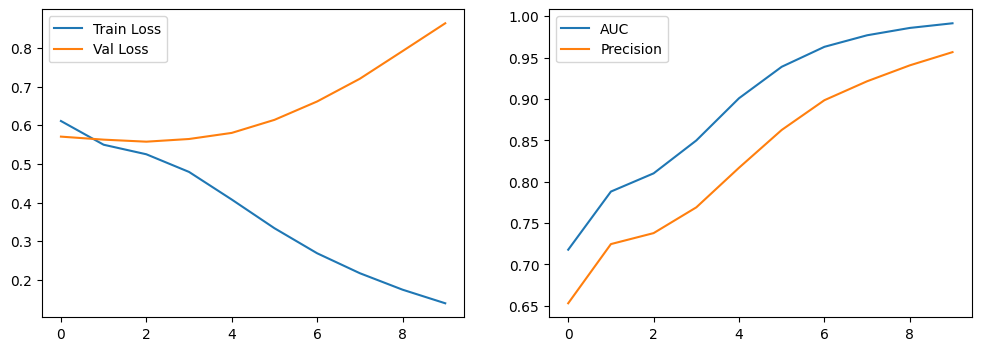

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='AUC')
plt.plot(history.history['ap'], label='Precision')
plt.legend()
plt.show()

model.save_weights('ncf_model.weights.h5')

In [20]:
def generate_recommendations_tf(model, user_id, n=10):
    all_item_ids = np.arange(1, num_items + 1, dtype=np.int64)
    user_ids = np.full(shape=(num_items,), fill_value=user_id, dtype=np.int64)

    predictions = model.predict(
        {'user_id': user_ids, 'item_id': all_item_ids},
        batch_size=1024,
        verbose=0
    ).flatten()

    items_df = pd.DataFrame({
        'item_id': all_item_ids,
        'score': predictions
    })

    user_rated_items = set(ratings_df[ratings_df['user_id'] == user_id]['item_id'].values)
    items_df = items_df[~items_df['item_id'].isin(user_rated_items)]

    top_n_items = items_df.sort_values('score', ascending=False).head(n)
    recommendations = pd.merge(top_n_items, movies_df[['item_id', 'title']], on='item_id')

    return recommendations[['item_id', 'title', 'score']]

In [21]:
test_users = [1, 42, 100]

for user_id in test_users:
    print(f"\nTop 10 recommendations for user {user_id}:")
    recommendations = generate_recommendations_tf(model, user_id, n=10)
    print(recommendations)

    print(f"\nMovies that user {user_id} has rated highly (4-5 stars):")
    user_liked = ratings_df[(ratings_df['user_id'] == user_id) & (ratings_df['rating'] >= 4)]
    user_liked = pd.merge(user_liked, movies_df[['item_id', 'title']], on='item_id')
    print(user_liked[['item_id', 'title', 'rating']])


Top 10 recommendations for user 1:
   item_id                          title     score
0      479                 Vertigo (1958)  0.999876
1     1288         Denise Calls Up (1995)  0.999858
2      513          Third Man, The (1949)  0.999834
3      992        Head Above Water (1996)  0.999825
4     1062  Four Days in September (1997)  0.999810
5     1124     Farewell to Arms, A (1932)  0.999530
6      515               Boot, Das (1981)  0.999503
7      525          Big Sleep, The (1946)  0.999483
8     1537                    Cosi (1996)  0.999479
9     1169                   Fresh (1994)  0.999478

Movies that user 1 has rated highly (4-5 stars):
     item_id                            title  rating
0         61       Three Colors: White (1994)       4
1         33                 Desperado (1995)       4
2        160       Glengarry Glen Ross (1992)       4
3         20        Angels and Insects (1995)       4
4        202             Groundhog Day (1993)       5
..       ...      

In [22]:
def evaluate_hit_ratio(model, test_df, ratings_df, n=10):
    hits = []
    user_ids = test_df['user_id'].unique()
    all_item_ids = ratings_df['item_id'].unique()

    print("Calculating Hit Ratio @ 10...")
    for user_id in tqdm(user_ids):
        # 1. Get the item the user actually liked (the "Ground Truth")
        ground_truth_item = test_df[test_df['user_id'] == user_id]['item_id'].values[0]

        # 2. Select 99 random items the user hasn't interacted with
        interacted_items = set(ratings_df[ratings_df['user_id'] == user_id]['item_id'])
        non_interacted_items = list(set(all_item_ids) - interacted_items)
        negative_samples = random.sample(non_interacted_items, 99)

        # 3. Combine to create a test set of 100 items
        test_items = np.array([ground_truth_item] + negative_samples)
        user_input = np.full(len(test_items), user_id)

        # 4. Predict scores
        preds = model.predict(
            {'user_id': user_input, 'item_id': test_items},
            batch_size=100,
            verbose=0
        ).flatten()

        # 5. Rank items: Did the ground truth item make the Top N?
        top_n_indices = preds.argsort()[-n:][::-1]
        top_n_items = test_items[top_n_indices]

        if ground_truth_item in top_n_items:
            hits.append(1)
        else:
            hits.append(0)

    return np.mean(hits)

# Usage
hr10 = evaluate_hit_ratio(model, test_df, ratings_df, n=10)
print(f"Hit Ratio @ 10: {hr10:.4f}")

Calculating Hit Ratio @ 10...


100%|██████████| 940/940 [01:02<00:00, 15.06it/s]

Hit Ratio @ 10: 0.1840


In [23]:
# So ass! The hell!

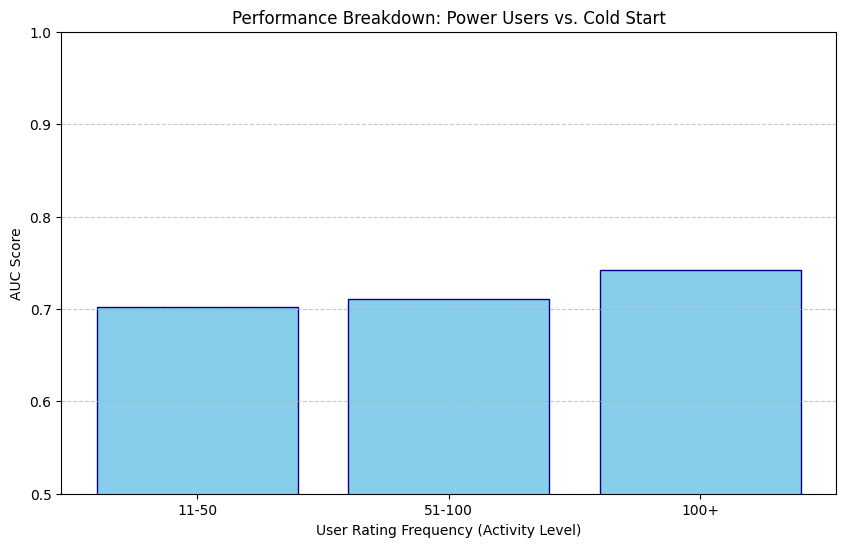

In [26]:
user_rating_counts = ratings_df.groupby('user_id')['item_id'].agg(count='count').reset_index()
user_rating_counts['group'] = pd.cut(user_rating_counts['count'],
                                   bins=[0, 10, 50, 100, float('inf')],
                                   labels=['1-10', '11-50', '51-100', '100+'])

user_groups = {group: user_rating_counts[user_rating_counts['group'] == group]['user_id'].values
               for group in user_rating_counts['group'].unique()}

def evaluate_by_user_group_tf(model, test_df, user_groups):
    results = {}

    for group_name, user_ids in user_groups.items():
        group_ratings = test_df[test_df['user_id'].isin(user_ids)]

        if group_ratings.empty:
            continue

        inputs = {
            'user_id': group_ratings['user_id'].values,
            'item_id': group_ratings['item_id'].values
        }
        true_labels = group_ratings['label'].values

        predictions = model.predict(inputs, verbose=0).flatten()

        from sklearn.metrics import roc_auc_score
        try:
            if len(np.unique(true_labels)) > 1:
                auc = roc_auc_score(true_labels, predictions)
                results[group_name] = auc
            else:
                results[group_name] = None
        except:
            results[group_name] = None

    return results

group_performance = evaluate_by_user_group_tf(model, test_df, user_groups)

order = ['1-10', '11-50', '51-100', '100+']
groups = [g for g in order if g in group_performance and group_performance[g] is not None]
aucs = [group_performance[g] for g in groups]

plt.figure(figsize=(10, 6))
plt.bar(groups, aucs, color='skyblue', edgecolor='navy')
plt.xlabel('User Rating Frequency (Activity Level)')
plt.ylabel('AUC Score')
plt.title('Performance Breakdown: Power Users vs. Cold Start')
plt.ylim(0.5, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [27]:
def evaluate_hit_ratio_by_group(model, test_df, ratings_df, user_groups, n=10):
    group_hr = {}
    all_item_ids = ratings_df['item_id'].unique()

    for group_name, user_ids in user_groups.items():
        # Filter test set for this group
        group_test_df = test_df[test_df['user_id'].isin(user_ids)]

        if group_test_df.empty:
            continue

        hits = []
        print(f"Evaluating Hit Ratio for group: {group_name}")

        for user_id in tqdm(group_test_df['user_id'].unique(), desc=f"Group {group_name}"):
            # 1. Get Ground Truth
            gt_item = group_test_df[group_test_df['user_id'] == user_id]['item_id'].values[0]

            # 2. Sample 99 Negatives
            interacted = set(ratings_df[ratings_df['user_id'] == user_id]['item_id'])
            non_interacted = list(set(all_item_ids) - interacted)
            negatives = random.sample(non_interacted, 99)

            # 3. Predict
            test_items = np.array([gt_item] + negatives)
            user_input = np.full(len(test_items), user_id)

            preds = model.predict(
                {'user_id': user_input, 'item_id': test_items},
                batch_size=100,
                verbose=0
            ).flatten()

            # 4. Check Hit
            top_n = test_items[preds.argsort()[-n:][::-1]]
            hits.append(1 if gt_item in top_n else 0)

        group_hr[group_name] = np.mean(hits) if hits else 0

    return group_hr

# Execute
hr_results = evaluate_hit_ratio_by_group(model, test_df, ratings_df, user_groups)

Evaluating Hit Ratio for group: 100+


Group 100+: 100%|██████████| 361/361 [00:28<00:00, 12.88it/s]


Evaluating Hit Ratio for group: 51-100


Group 51-100: 100%|██████████| 202/202 [00:13<00:00, 15.25it/s]


Evaluating Hit Ratio for group: 11-50


Group 11-50: 100%|██████████| 377/377 [00:36<00:00, 10.22it/s]


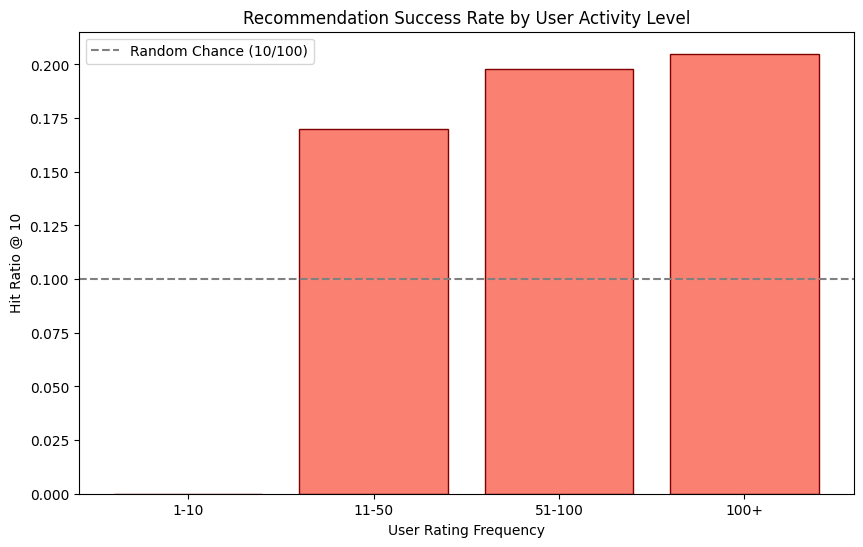

Hit Ratio @ 10 for 1-10: 0.0000
Hit Ratio @ 10 for 11-50: 0.1698
Hit Ratio @ 10 for 51-100: 0.1980
Hit Ratio @ 10 for 100+: 0.2050


In [28]:
plt.figure(figsize=(10, 6))
group_names = ['1-10', '11-50', '51-100', '100+']
hr_values = [hr_results.get(g, 0) for g in group_names]

plt.bar(group_names, hr_values, color='salmon', edgecolor='maroon')
plt.axhline(y=0.1, color='gray', linestyle='--', label='Random Chance (10/100)')
plt.xlabel('User Rating Frequency')
plt.ylabel('Hit Ratio @ 10')
plt.title('Recommendation Success Rate by User Activity Level')
plt.legend()
plt.show()

for group, hr in zip(group_names, hr_values):
    print(f"Hit Ratio @ 10 for {group}: {hr:.4f}")

In [29]:
def analyze_predictions_tf(model, test_loader):
    predictions = model.predict(test_loader).flatten()
    true_labels = np.concatenate([y for x, y in test_loader], axis=0)

    results_df = pd.DataFrame({
        'true_label': true_labels,
        'predicted_score': predictions
    })

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(x=results_df['predicted_score'].to_numpy(), bins=30, kde=True, color='teal')
    plt.title('Distribution of Predicted Scores')
    plt.xlabel('Predicted Score')
    plt.ylabel('Count')

    plt.subplot(1, 2, 2)
    sns.boxplot(x='true_label', y='predicted_score', data=results_df, palette='Set2')
    plt.title('Predicted Scores by True Label')
    plt.xlabel('True Label (0=Negative, 1=Positive)')
    plt.ylabel('Predicted Score')

    plt.tight_layout()
    plt.show()

    avg_scores = results_df.groupby('true_label')['predicted_score'].mean()
    print("\nAverage prediction scores:")
    for label, score in avg_scores.items():
        print(f"Items with Label {label}: {float(score):.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


/tmp/ipython-input-3505636196.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='true_label', y='predicted_score', data=results_df, palette='Set2')


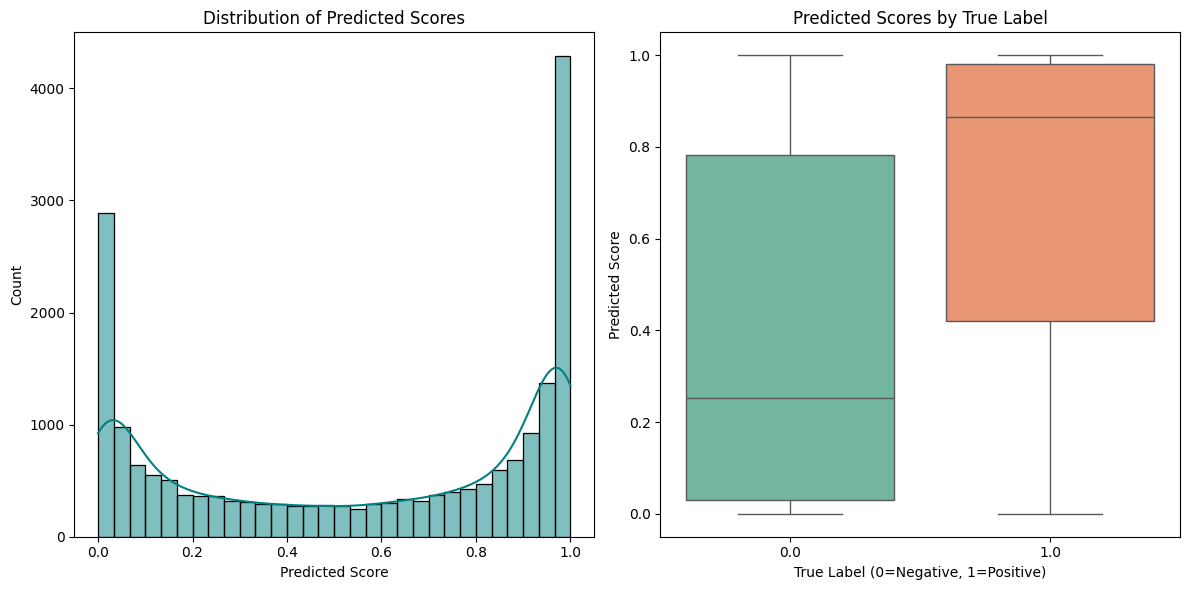


Average prediction scores:
Items with Label 0.0: 0.3906
Items with Label 1.0: 0.6938


In [30]:
analyze_predictions_tf(model, test_loader)